### This is the class implementation of the codes. The function-by-function implemetation is contained in the 'food_drug_predict' file.

In [163]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [164]:
class Predicts:
    '''
    This class harbours all the functions necessary for making predictions in this work.
    
    Params:
    1. dbase - A csv database of object fingerprints with their corresponding name labels.
    
    Note: When using this class, make sure you wrap the 'dbase' value in a quotaion mark as: 'dbase.csv'.
    
    2. finger_print - A list containing only the fingerprints of an object to be identified.
    
    Return:
    1. A list of lists of the predicted substance(s) with their averaged values.
    2. A list of lists of the unlikely substances with their averaged values.
    3. A plot of the predicted substance(s) with their averaged values
    4. A plot of the unlikely substances with their averaged values.
    '''       
    def __init__(self, dbase, finger_print):
        
        # Instantiate the arguments
        self.dbase = dbase
        self.finger_print = finger_print
                
        self.df = pd.read_csv(dbase)
                   
    
    def val_ave(self):
        '''
        This function performs element-wise addition and averaging of the numerical values of the datasets, 
        substance-by-substance. At the end it produces a dataset of these values together with their corresponding substances.

        Params: self.df - Dataframe of fingerprints (numerical values) with their corresponding substance labels, inherited 
        from the parent class. One important condition is that all the substances must be scanned for equal number of times.

        Return: Returns a list of lists of the averaged datasets, with their corresponding substance labels.
        '''
        vals_list = np.zeros(18)
        cnt = 0
        num_scan = len(self.df.values)/len(self.df.Substance.unique()) # Number of scans of eah substance
        vals_lists = []

        for subs in list(self.df.Substance.unique()):
            for vals in self.df.values:
                if vals[-1] == subs: # vals[-1] is the last element in the list which is the substance
                    cnt += 1
                    vals_list = np.add(vals_list, np.array(vals[:-1])) # Element-wise addition. vals[:-1] is a list of only the 
                                                                        # numerical values

                elif cnt == num_scan:
                    break

            vals_list /= num_scan # Element-wise averaging
            vals_list = np.around(list(vals_list))
            vals_list = list(vals_list)
            vals_list = [math.trunc(fin_list) for fin_list in vals_list] # Remove decimal points
            vals_list.append(subs)
            vals_lists.append(vals_list)
            cnt = 0
            vals_list = np.zeros(18)

        return  vals_lists


    def list_diffs(self):
        '''
        This function takes the element-wise differences between any new dataset of a substance and all the existing averaged 
        datasets from the database. The intention is to see how close these differences are to zero. If the new dataset is 
        exactly of equal values with any dataset in the list of lists, then the resulting difference dataset would come down 
        to zeros.
        Thereafter, a threshold of 100 was used to take the element-wise difference of all these values again. By so doing, 
        the closer the values are to 100, the more likely that substance is to predicted. Finally their absolute values were 
        taken.

        Note: The value of the threshold can be changed at will.

        Params: 
        1. finger_print - A dataset of a substance acquired in the form of a list of numerical values. This is inherited from 
        the parent class as finger_print. Note that the length of this list must be equal with the number of columns of the 
        database, excluding the substance name.

        2. The output of the 'val_ave' function.

        Return: Returns a list of lists containing the absolute values of the element-wise differences between the new object
        dataset and the existing datasets from the 'val_ave' function; and again between the threshold value and the resultant
        datasets.
        '''
        diffs_lists = []
        threshold = 100

        for lists in self.val_ave():
            diff_list = np.absolute(np.subtract(np.array(self.finger_print), np.array(lists[:-1])))
            diff_lists = list(np.absolute(np.subtract(threshold, diff_list)))
            diff_lists.append(lists[-1])
            diffs_lists.append(diff_lists)

        return diffs_lists
    
    
    def pairing(self):
        '''
        This function takes the average of each list in the resultant list of lists from the 'list_diffs' function. Each of 
        these average values is paired with its corresponding name label. The idea is that the most likely substance would have 
        an average value very close to the threshold (100 in this case).

        Param: The output of the 'list_diffs' function.

        Return: Returns a list of pairs of lists containing the average values and their corresponding object name labels.
        '''
        div_list = []
        div_lists = []
        added = 0
        for my_list in self.list_diffs():
            divided = 0
            for element in my_list[:-1]:
                added += element
            divided = added / len(my_list[:-1])    
            div_list = list(np.append(my_list[-1], int(divided)))
            div_lists.append(div_list)
            added = 0

        return div_lists
    
    
    def collections(self):
        '''
        This function carries out the prediction proper, by comparing the individual average values with a range set with 'min'
        and 'max' variables. 

        Note: The value of these variables can be changed at will.

        Params: The output of the 'pairing' function.

        Return:
        1. A list of lists of the predicted substance(s) with their averaged values.
        2. A list of lists of the unlikely substances with their averaged values.
        3. A plot of the predicted substance(s) with their averaged values
        4. A plot of the unlikely substances with their averaged values.
        '''
        cnt = 0
        min = 50
        max = 373
        coll_1 = []
        coll_2 = []
        obj_coll_1 = []
        val_coll_1 = []
        obj_coll_2 = []
        val_coll_2 = []
        for pairs in self.pairing():
            cnt += 1
            if min <= int(pairs[-1]) <= max:
                coll_1.append(pairs) # Creating a list for the more likely substance(s)

            else:
                coll_2.append(pairs) # Creating a list for the less likely substances

        for packs in coll_2:
            obj_coll_2.append(packs[0])
            val_coll_2.append(int(packs[1]))

        # Plot for the less likely substances
        plt.bar(obj_coll_2, val_coll_2, color='orange')
        plt.xlabel('Substances')
        plt.ylabel('Proportion')
        plt.title('Less likely Substance(s)')
        plt.show()

        if (cnt == len(self.pairing())) and (len(coll_1) == 0):
            return 'No matching substance!', 'Available substances: {}'.format(coll_2)
        else:
            for pack in coll_1:
                obj_coll_1.append(pack[0])
                val_coll_1.append(int(pack[1]))

            # Plot for the more likely substance(s)
            plt.bar(obj_coll_1, val_coll_1, color='green')
            plt.xlabel('Substances')
            plt.ylabel('Proportion')
            plt.title('Likely Substance(s)')
            plt.show()

            return 'More likely substance(s): {}'.format(coll_1), 'Less likely substance(s): {}'.format(coll_2)
        

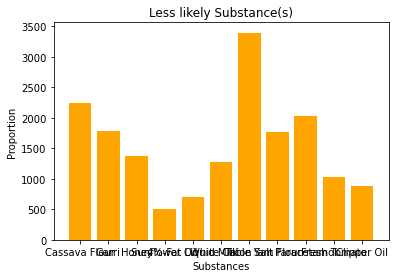

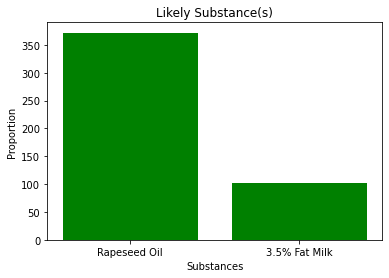

More likely substance(s): [['Rapeseed Oil', '372'], ['3.5% Fat Milk', '102']]
Less likely substance(s): [['Cassava Flour', '2246'], ['Garri', '1783'], ['Honey', '1382'], ['Sunflower Oil', '497'], ['4%-Fat Liquid Milk', '707'], ['White Onion', '1273'], ['Table Salt', '3395'], ['Yam Flour', '1765'], ['Paracetamol', '2025'], ['Fresh Tomato', '1027'], ['Clipper Oil', '887']]


In [165]:
garri = [186, 399, 350, 561, 7108, 15672, 570, 854, 6411, 630, 968, 513, 294, 222, 288, 230, 12735, 3737]
honey = [70, 141, 101, 155, 1514, 3401, 189, 270, 1564, 261, 262, 157, 186, 255, 244, 163, 2468, 673]
milk_4 = [141, 245, 187, 308, 3540, 7341, 534, 622, 25661, 702, 2956, 390, 544, 518, 575, 432, 5721, 1523]
milk_3 = [129, 235, 176, 294, 3498, 7143, 437, 519, 15898, 612, 1892, 328, 356, 272, 370, 313, 5093, 1323]
milks_3 = [179, 285, 258, 349, 3643, 7307, 484, 566, 15394, 655, 1873, 377, 401, 316, 416, 357, 5146, 1361]
milks3 = [129, 235, 178, 299, 3593, 7257, 434, 516, 15344, 605, 1823, 327, 351, 266, 366, 307, 5096, 1311]
unknown = [231, 336, 278, 398, 3655, 7310, 547, 626, 16411, 725, 2033, 433, 463, 378, 477, 419, 5201, 1419]

#milks3 = [23, 24]
vals_lists = Predicts('objdbase.csv', milks3)
coll_1, coll_2 = vals_lists.collections()
print(coll_1)
print(coll_2)